In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from imblearn.under_sampling import RandomUnderSampler

In [35]:
# Read in data and split for training and testing
data = pd.read_csv("heart_2020_original.csv")
data.drop(["Race"], axis=1, inplace=True)
train_data = data.sample(frac=0.75, random_state=21)
test_data = data.drop(train_data.index)

# Get heart disease distribution
data["HeartDisease"].value_counts(normalize=True)

# Only 8.5% target heart disease so use undersampling for a better model
rus = RandomUnderSampler(random_state=21)
X_train_data_us, Y_train_data_us = rus.fit_resample(train_data.drop(["HeartDisease"], axis=1), train_data["HeartDisease"])

# Merge undersampled data for ease of reading with CSV
train_data_us = pd.concat([Y_train_data_us, X_train_data_us], axis=1)

# Output CSVs for loading in BN
train_data_us.to_csv("heart_train.csv", index=False)
test_data.to_csv("heart_test.csv", index=False)

In [54]:
# Define BN topology
bn = gum.BayesNet("Heart Disease Prediction")

bn.add(gum.LabelizedVariable("HeartDisease", "HeartDisease", ["Yes", "No"]))
bn.add(gum.DiscretizedVariable("BMI", "BMI").addTick(0).addTick(18.5).addTick(25).addTick(30).addTick(100))
bn.add(gum.LabelizedVariable("Smoking", "Smoking", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("AlcoholDrinking",
       "AlcoholDrinking", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("Stroke", "Stroke", ["Yes", "No"]))
bn.add(gum.DiscretizedVariable("PhysicalHealth", "PhysicalHealth").addTick(0).addTick(1).addTick(4).addTick(10).addTick(30))
bn.add(gum.DiscretizedVariable("MentalHealth", "MentalHealth").addTick(
    0).addTick(1).addTick(4).addTick(10).addTick(30))
bn.add(gum.LabelizedVariable("DiffWalking", "DiffWalking", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("Sex", "Sex", ["Male", "Female"]))
bn.add(gum.LabelizedVariable("AgeCategory", "AgeCategory", [
       "18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80 or older"]))
bn.add(gum.LabelizedVariable("Diabetic", "Diabetic", [
       "Yes", "No", "No, borderline diabetes", "Yes (during pregnancy)"]))
bn.add(gum.LabelizedVariable("PhysicalActivity", "PhysicalActivity", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("GenHealth", "GenHealth", ["Very good", "Good", "Excellent", "Fair", "Poor"]))
bn.add(gum.DiscretizedVariable("SleepTime", "SleepTime").addTick(0).addTick(3).addTick(5).addTick(7).addTick(9).addTick(12).addTick(24))
bn.add(gum.LabelizedVariable("Asthma", "Asthma", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("KidneyDisease", "KidneyDisease", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("SkinCancer", "SkinCancer", ["Yes", "No"]))


16

In [37]:
# View nodes added
print(bn.variable("HeartDisease"))
print(bn.variable("BMI"))
print(bn.variable("Smoking"))
print(bn.variable("AlcoholDrinking"))
print(bn.variable("Stroke"))
print(bn.variable("PhysicalHealth"))
print(bn.variable("MentalHealth"))
print(bn.variable("DiffWalking"))
print(bn.variable("Sex"))
print(bn.variable("AgeCategory"))
print(bn.variable("Diabetic"))
print(bn.variable("PhysicalActivity"))
print(bn.variable("GenHealth"))
print(bn.variable("SleepTime"))
print(bn.variable("Asthma"))
print(bn.variable("KidneyDisease"))
print(bn.variable("SkinCancer"))

bn

HeartDisease:Labelized({Yes|No})
BMI:Discretized(<[0;18.5[,[18.5;25[,[25;30[,[30;100]>)
Smoking:Labelized({Yes|No})
AlcoholDrinking:Labelized({Yes|No})
Stroke:Labelized({Yes|No})
PhysicalHealth:Discretized(<[0;1[,[1;4[,[4;10[,[10;30]>)
MentalHealth:Discretized(<[0;1[,[1;4[,[4;10[,[10;30]>)
DiffWalking:Labelized({Yes|No})
Sex:Labelized({Male|Female})
AgeCategory:Labelized({18-24|25-29|30-34|35-39|40-44|45-49|50-54|55-59|60-64|65-69|70-74|75-79|80 or older})
Diabetic:Labelized({Yes|No|No, borderline diabetes|Yes (during pregnancy)})
PhysicalActivity:Labelized({Yes|No})
GenHealth:Labelized({Very good|Good|Excellent|Fair|Poor})
SleepTime:Discretized(<[0;3[,[3;5[,[5;7[,[7;9[,[9;12[,[12;24]>)
Asthma:Labelized({Yes|No})
KidneyDisease:Labelized({Yes|No})
SkinCancer:Labelized({Yes|No})


(pyAgrum.BayesNet<double>@0x7fd73547d600) BN{nodes: 17, arcs: 0, domainSize: 10^8.0096, dim: 60}

In [55]:
# Define the BN structure

links = [("MentalHealth", "GenHealth"), 
         ("SleepTime", "GenHealth"), 
         ("PhysicalHealth", "GenHealth"), 
         ("GenHealth", "HeartDisease"), 
         ("GenHealth", "DiffWalking"),
         ("Smoking", "HeartDisease"),
         ("Smoking", "DiffWalking"),
         ("AgeCategory", "HeartDisease"),
         ("AgeCategory", "DiffWalking"),
         ("HeartDisease", "DiffWalking"),
         ("KidneyDisease", "HeartDisease"),
         ("Stroke", "HeartDisease"),
         ("Diabetic", "HeartDisease"),
         ("Diabetic", "KidneyDisease")]
""" ("SkinCancer", "HeartDisease"),
         ("PhysicalActivity", "BMI"),
         ("PhysicalActivity", "PhysicalHealth"),
         ("BMI", "Diabetic"),
         ("BMI", "Stroke"),
         ("AlcoholDrinking", "GenHealth")] """

for link in links:
    bn.addArc(*link)

In [50]:
# Visualise the network with arcs
bn

(pyAgrum.BayesNet<double>@0x7fd73099ce00) BN{nodes: 17, arcs: 20, domainSize: 10^8.0096, dim: 9883}

In [56]:
# Learn the parameters of the BN
learner = gum.BNLearner("heart_train.csv", bn)
learner.useSmoothingPrior(1) # TODO: Remove this...
bn = learner.learnParameters(bn.dag())

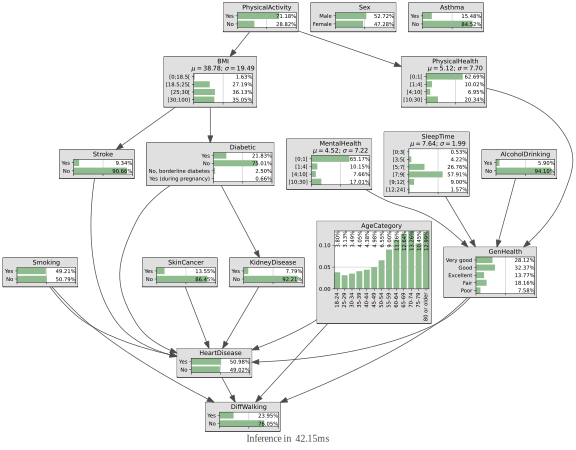

In [52]:
# View learned model
gnb.showInference(bn)

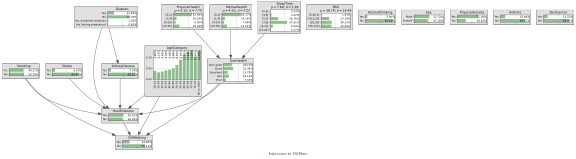

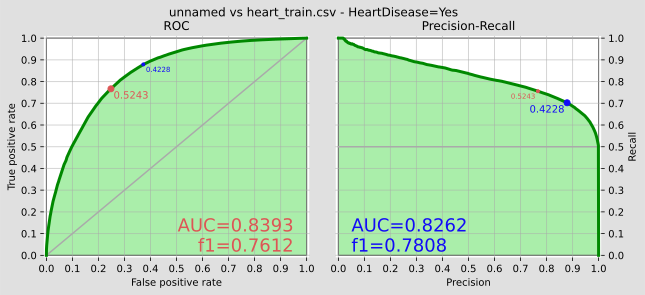

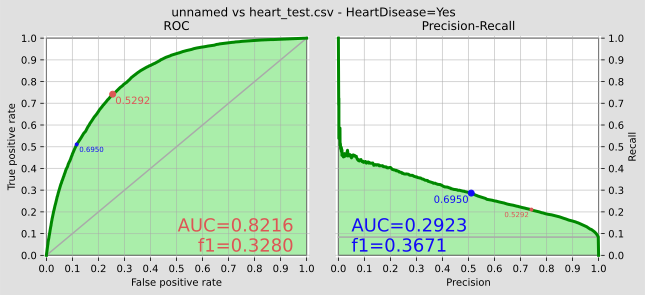

(0.8215929185159334, 0.5292435459, 0.2923325174059778, 0.6949659393500001)

In [57]:
# Delete from here

from pyAgrum.lib.bn2roc import showROC_PR
import pyAgrum.lib.explain as explain

explain.showInformation(bn)
gnb.showInference(bn)

showROC_PR(bn, "heart_train.csv", "HeartDisease", "Yes", False, True)
showROC_PR(bn, "heart_test.csv", "HeartDisease", "Yes", False, True)

In [ ]:
# Delete this; just to see how things would turn out if fully automated modelling

from sklearn.metrics import accuracy_score
import pyAgrum.skbn as skbn
from pyAgrum.lib.bn2roc import showROC_PR
import pyAgrum.lib.explain as explain
learner = gum.BNLearner("heart_train.csv", bn)
bn = learner.learnBN()

# View model structure
print(bn.variable("HeartDisease"))
print(bn.variable("BMI"))
print(bn.variable("Smoking"))
print(bn.variable("AlcoholDrinking"))
print(bn.variable("Stroke"))
print(bn.variable("PhysicalHealth"))
print(bn.variable("MentalHealth"))
print(bn.variable("DiffWalking"))
print(bn.variable("Sex"))
print(bn.variable("AgeCategory"))
print(bn.variable("Diabetic"))
print(bn.variable("PhysicalActivity"))
print(bn.variable("GenHealth"))
print(bn.variable("SleepTime"))
print(bn.variable("Asthma"))
print(bn.variable("KidneyDisease"))
print(bn.variable("SkinCancer"))

bn

explain.showInformation(bn)
gnb.showInference(bn)

showROC_PR(bn, "heart_test.csv", "HeartDisease", "Yes", False, True)


train = pd.read_csv("heart_train.csv")
test = pd.read_csv("heart_test.csv")

target = "HeartDisease"

x_train = train.drop(target, axis=1)
y_train = train[target]
x_test = test.drop(target, axis=1)
y_test = test[target]

bn = skbn.BNClassifier(prior="NoPrior")
bn.fit(x_train, y_train)
y_test_pred = bn.predict(x_test)

print(accuracy_score(y_test, y_test_pred))
